# Sentiment Analysis on IMDb Movie Reviews with Linear Classifiers

The dataset used is the Kaggle Bag of Words Meets Bags of Popcorn dataset, found here: https://www.kaggle.com/c/word2vec-nlp-tutorial/data. The labelled data set consists of 50,000 IMDb movie reviews, specially selected for sentiment analysis. The sentiment of reviews is binary, meaning the IMDb rating < 5 results in a sentiment score of 0, and rating >=7 have a sentiment score of 1. No individual movie has more than 30 reviews.

The purpose of this notebook is to learn a classifier from this data set. Three methods will be used to conduct sentiment analysis:
+ Logistic Regression 
+ Support Vector Machines
+ Naive Bayes

## 1. Load and explore the data

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import metrics

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlottefettes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
train = pd.read_csv("imdb_reviews/labeledTrainData.tsv", delimiter="\t")

In [3]:
train.head()

id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...

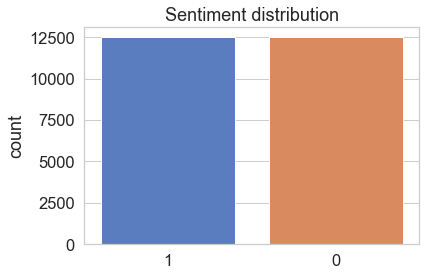

In [4]:
f = sns.countplot(x='sentiment', data=train)
f.set_title("Sentiment distribution")
f.set_xticklabels([1, 0])
plt.xlabel("");

In [5]:
text = " ".join(review for review in train.review)


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english")).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

In [6]:
#separate sentences from labels
sentences = train.review.to_list()
labels = train.sentiment.to_list()

#transform labels from '0 v.s. 1' to '-1 v.s. 1'
y = np.array(labels, dtype='int8')
y = 2 * y - 1

## 2. Preprocess the data

In [7]:
#remove punctuation and numbers
#function that removes unwanted characters specified in removal list
#returns x with all the characters in removal_list replaced by ' '
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

#remove digits
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

#remove punctuation
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]


In [8]:
#convert all to lower-case
sents_lower = [x.lower() for x in punc_less]

In [9]:
#filter out stop words as considered as not providing any useful information
#define stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from', 'br'])

#remove stop words
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

In [10]:
#example
sents_processed[0:10]

['with all this stuff going down at moment with mj ve started listening his music watching odd documentary here and there watched wiz and watched moonwalker again maybe just want get certain insight into this guy who thought was really cool in eighties just maybe make up my mind whether is guilty or innocent moonwalker is part biography part feature film which remember going see at cinema when was originally released some has subtle messages about mj s feeling towards press and also obvious message drugs are bad m kay visually impressive but course this is all about michael jackson so unless you remotely like mj in anyway then you are going hate this and find boring some may call mj egotist for consenting making this movie but mj and most his fans would say that made for fans which if true is really nice him actual feature film bit when finally starts is only on for minutes or so excluding smooth criminal sequence and joe pesci is convincing as psychopathic all powerful drug lord why w

### Bag of words

To use linear classifiers on the data, need to transform textual into numeric data using the bag of words representation, where each word corresponds to a number and each sentence is represented as a vector.

CountVectorizer class in scikit-learn will be used to do this, capping feature number at 4500 (only the most common 4500 words in the corpus will make it to the vocabulary).

TF-IDF will also be used.

#### Count Vectorizer

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
sents_processed2 = sents_processed.copy()
#transform to bag of words representation
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 4500)
data_features_cv = vectorizer.fit_transform(sents_processed2)

#### Tfidf Vectorizer

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
#improvements with TfidfVectorizer class
sents_processed3 = sents_processed.copy()
tf_idf_vect = TfidfVectorizer(ngram_range=(1, 2))
data_features_tf = tf_idf_vect.fit_transform(sents_processed3)

### Train/test split

#### With CountVectorizer

In [13]:
#split data into test and train sets
np.random.seed(0)
test_inds_cv = np.append(np.random.choice((np.where(y==-1))[0], 5000, replace=False), np.random.choice((np.where(y==1))[0], 5000, replace=False))
train_inds_cv = list(set(range(len(labels))) - set(test_inds_cv))

train_data_cv = data_features_cv[train_inds_cv,]
train_labels_cv = y[train_inds_cv]

test_data_cv = data_features_cv[test_inds_cv,]
test_labels_cv = y[test_inds_cv]

print("train data cv: ", train_data_cv.shape)
print("train labels cv: ", train_labels_cv.shape)
print("test data cv: ", test_data_cv.shape)
print("test labels cv: ", test_labels_cv.shape)

train data cv:  (15000, 4500)
train labels cv:  (15000,)
test data cv:  (10000, 4500)
test labels cv:  (10000,)


#### With Tfidf

In [14]:
np.random.seed(0)
test_inds_tf = np.append(np.random.choice((np.where(y==-1))[0], 5000, replace=False), np.random.choice((np.where(y==1))[0], 5000, replace=False))
train_inds_tf = list(set(range(len(labels))) - set(test_inds_tf))

train_data_tf = data_features_tf[train_inds_tf,]
train_labels_tf = y[train_inds_tf]

test_data_tf = data_features_tf[test_inds_tf,]
test_labels_tf = y[test_inds_tf]

print("train data tf: ", train_data_tf.shape)
print("train labels tf: ", train_labels_tf.shape)
print("test data tf: ", test_data_tf.shape)
print("test labels tf: ", test_labels_tf.shape)

train data tf:  (15000, 1687638)
train labels tf:  (15000,)
test data tf:  (10000, 1687638)
test labels tf:  (10000,)


## 3. Building the models

### Logistic Regression

In [15]:
X_train_lr = train_data_cv.copy()
y_train_lr = train_labels_cv.copy()
X_test_lr = test_data_cv.copy()
y_test_lr = test_labels_cv.copy()

In [16]:
from sklearn.linear_model import SGDClassifier

#fit logistic classifier on training data
clf = SGDClassifier(loss="log", penalty="none")
clf.fit(X_train_lr, y_train_lr)

#pull out parameters (w,b) of logistic regression model
w = clf.coef_[0,:]
b = clf.intercept_

#get predictions on training and test data
preds_train_lr = clf.predict(X_train_lr)
preds_test_lr = clf.predict(X_test_lr)

#compute errors
errs_train_lr = np.sum((preds_train_lr > 0.0) != (y_train_lr > 0.0))
errs_test_lr = np.sum((preds_test_lr > 0.0) != (y_test_lr > 0.0))

print("Training error: ", float(errs_train_lr)/len(y_train_lr))
print("Test error: ", float(errs_test_lr)/len(y_test_lr))

Training error:  0.05006666666666667
Test error:  0.1484


In [17]:
#model accuracy
print("Accuracy:",metrics.accuracy_score(y_test_lr, preds_test_lr))

Accuracy: 0.8516


In [18]:
print(classification_report(y_test_lr, preds_test_lr))

              precision    recall  f1-score   support

          -1       0.85      0.85      0.85      5000
           1       0.85      0.86      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



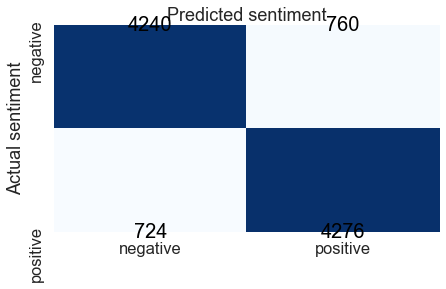

In [19]:
cnf_matrix_lr = confusion_matrix(y_test_lr, preds_test_lr)

class_names = ["negative", "positive"]
fig,ax = plt.subplots()

annot_kws = {"ha": 'left',"va": 'center'}

sns.heatmap(pd.DataFrame(cnf_matrix_lr), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 20, "color":'black'})
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');

#### Analysing the margin

Logistic regression produces conditional probability estimates as well as classifications. To be classified as positive, probability of y = 1 given x values must be 50% or more (and so to be classified as negative, the probability of y = 1 given x values must be less than 50%). 

The data can be analysed in terms of how closely it sits to this 50% conditional probability boundary. By considering margins that sit +/- a specified distance from the 50% boundary, the fraction of data points lying above this margin will give an indication of, in a sense, how certain the classifier is for data points. With a margin, for example, of 0.3, this is 0.3 away from the 50% boundary on both sides, and so the data points above the margins would have 80% confidence. 

In [20]:
def margin_counts(clf, test_data, gamma):
    #compute probability on each test point
    preds = clf.predict_proba(test_data)[:,1]
    #find data points for which prediction is at least gamma away from 0.5
    margin_inds = np.where((preds > (0.5+gamma)) | (preds < (0.5-gamma)))[0]
    
    return float(len(margin_inds))

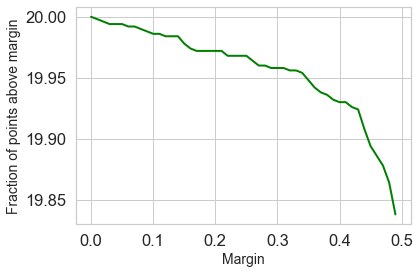

In [21]:
gammas = np.arange(0,0.5,0.01) #gamma is the size of the margin
f = np.vectorize(lambda g: margin_counts(clf, X_test_lr, g))
plt.plot(gammas, f(gammas)/500.0, linewidth=2, color='green')
plt.xlabel('Margin', fontsize=14)
plt.ylabel('Fraction of points above margin', fontsize=14)
plt.show()

This shows that the higher the margin gets, the lower the fraction of points above the margin. This highlights the fact that different reviews have different levels of confidence as to whether they are positive or negative. However, even at just below 0.5 margin (almost 100% confidence), around 85% of the points lie above the margin, which suggests for much of the data there is a high level of confidence in their classification.

The relationship between margin and error rate can also be analysed. Given that a wider margin means a higher confidence level for those points lying above it, it is anticipated that as margin increases, error rate will decrease.

In [22]:
#return error of predictions
def margin_errors(clf, test_data, test_labels, gamma):
    #compute prob on each test point
    preds = clf.predict_proba(test_data)[:,1]
    
    #find data points where prediction at least margin size away from 0.5
    margin_inds = np.where((preds > (0.5+gamma)) | (preds < (0.5-gamma)))[0]
    
    #error on those points
    num_errors = np.sum((preds[margin_inds] > 0.5) != (test_labels[margin_inds] > 0.0))
    
    return float(num_errors)/len(margin_inds)

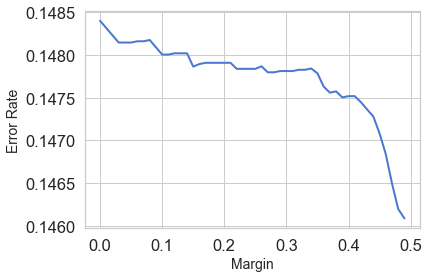

In [23]:
#create grid of gamma values
gammas = np.arange(0, 0.5, 0.01)

#compute errors on test data for each value of gamma
f = np.vectorize(lambda g: margin_errors(clf, X_test_lr, y_test_lr, g))

#plot
plt.plot(gammas, f(gammas), linewidth=2)
plt.ylabel('Error Rate', fontsize=14)
plt.xlabel('Margin', fontsize=14)
plt.show()

#### Influential words on the classification

In [24]:
#convert vocabulary into list
vocab = np.array([z[0] for z in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])

#get indices of sorting w
inds = np.argsort(w)

#words with large negative values
neg_inds = inds[0:50]
print("Highly negative words: ")
print([str(x) for x in list(vocab[neg_inds])])

#words with large positive values
pos_inds = inds[-49:-1]
print("Highly positive words: ")
print([str(x) for x in list(vocab[pos_inds])])

Highly negative words: 
['waste', 'worst', 'poorly', 'dull', 'awful', 'tries', 'poor', 'worse', 'disappointing', 'disappointment', 'wasted', 'fails', 'sadly', 'annoying', 'oh', 'save', 'intentions', 'laughable', 'ridiculous', 'grave', 'unfortunately', 'dumb', 'uninteresting', 'terrible', 'blah', 'painful', 'unfunny', 'wonder', 'pointless', 'boring', 'mess', 'unbelievable', 'ill', 'useless', 'cheap', 'christian', 'lacks', 'weak', 'supposed', 'lame', 'obnoxious', 'monsters', 'advice', 'stay', 'major', 'nonsense', 'okay', 'badly', 'couldn', 'alex']
Highly positive words: 
['themes', 'intense', 'wonderfully', 'dies', 'brooklyn', 'funniest', 'jackie', 'league', 'atmosphere', 'scared', 'nature', 'extraordinary', 'strong', 'fay', 'trek', 'solid', 'deserves', 'harsh', 'recommended', 'incredible', 'superb', 'episodes', 'davis', 'language', 'edge', 'refreshing', 'surprisingly', 'hilarious', 'lily', 'terrific', 'simple', 'genius', 'brilliant', 'today', 'loved', 'effective', 'noir', 'vs', 'gem', '

### Support Vector Machine

In [25]:
X_train_svm = train_data_cv.copy()
y_train_svm = train_labels_cv.copy()
X_test_svm = test_data_cv.copy()
y_test_svm = test_labels_cv.copy()

In [26]:
from sklearn import svm

#### Cross validation to find optimal C value 

In [27]:
def cross_validation_error(x,y,C_value,k):
    n = len(y)
    ## Randomly shuffle indices
    indices = np.random.permutation(n)
    
    ## Initialize error
    err = 0.0
    
    ## Iterate over partitions
    for i in range(k):
        ## Partition indices
        test_indices = indices[int(i*(n/k)):int((i+1)*(n/k) - 1)]
        train_indices = np.setdiff1d(indices, test_indices)
        
        ## Train classifier with parameter c
        clf = svm.LinearSVC(C=C_value, loss='hinge')
        clf.fit(x[train_indices], y[train_indices])
        
        ## Get predictions on test partition
        preds = clf.predict(x[test_indices])
        
        ## Compute error
        err += float(np.sum((preds > 0.0) != (y[test_indices] > 0.0)))/len(test_indices)
        
    return err/k

In [28]:
import warnings
warnings.filterwarnings('ignore')

#cvals limited as above 1.0 the is a failure to converge
cvals = [0.001,0.005,0.01,0.05,0.1]
for cval in cvals:
    error = cross_validation_error(X_train_svm, y_train_svm, cval, 1000)
    print('Error for a cval of {} is {}'.format(cval, error))

Error for a cval of 0.001 is 0.14649999999999952
Error for a cval of 0.005 is 0.12785714285714175
Error for a cval of 0.01 is 0.12499999999999903
Error for a cval of 0.05 is 0.13421428571428504
Error for a cval of 0.1 is 0.14007142857142785


#### Train and test the model with optimal C value

In [45]:
clf = svm.LinearSVC(C=0.01, loss='hinge')
clf.fit(X_train_svm, y_train_svm)
preds_svm = clf.predict(X_test_svm)
error = float(np.sum((preds_svm > 0.0) != (y_test_svm > 0.0)))/len(y_test_svm)
print("Test error: ", error)

Test error:  0.1266


In [46]:
#model accuracy
print("Accuracy:",metrics.accuracy_score(y_test_svm, preds_svm))

Accuracy: 0.8734


In [47]:
print(classification_report(y_test_svm, preds_svm))

              precision    recall  f1-score   support

          -1       0.88      0.86      0.87      5000
           1       0.87      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



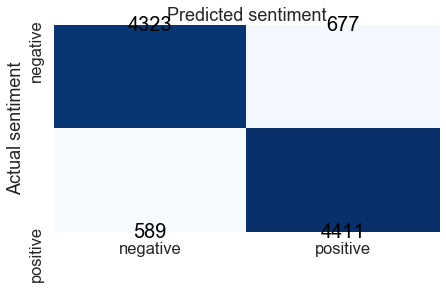

In [48]:
cnf_matrix_svm = confusion_matrix(y_test_svm, preds_svm)

class_names = ["negative", "positive"]
fig,ax = plt.subplots()

sns.heatmap(pd.DataFrame(cnf_matrix_svm), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 20, "color":'black'})
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');

### Naive Bayes

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

#### With CountVectorizer

In [50]:
X_train_nb1 = train_data_cv.copy()
y_train_nb1 = train_labels_cv.copy()
X_test_nb1 = test_data_cv.copy()
y_test_nb1 = test_labels_cv.copy()

In [51]:
alpha_range = list(np.arange(1,50,5))
len(alpha_range)

10

In [52]:
alpha_scores=[]

for a in alpha_range:
    clf = MultinomialNB(alpha=a)
    scores = cross_val_score(clf, X_train_nb1, y_train_nb1, cv=5, scoring='accuracy')
    alpha_scores.append(scores.mean())
    print(a,scores.mean())

1 0.8320000000000001
6 0.8314666666666668
11 0.8303333333333333
16 0.8284666666666667
21 0.8281333333333333
26 0.8276666666666668
31 0.8262
36 0.825
41 0.8238666666666667
46 0.8228


In [53]:
MSE = [1 - x for x in alpha_scores]

#alpha that minimises error
optimal_alpha_bnb = alpha_range[MSE.index(min(MSE))]

print(optimal_alpha_bnb)

1


In [54]:
nb = MultinomialNB(alpha=1)

nb.fit(X_train_nb1, y_train_nb1)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [55]:
y_pred_nb1 = nb.predict(X_test_nb1)

In [56]:
#model accuracy
print("Accuracy:",metrics.accuracy_score(y_test_nb1, y_pred_nb1))

Accuracy: 0.8327


In [57]:
print(classification_report(y_test_nb1, y_pred_nb1))

              precision    recall  f1-score   support

          -1       0.82      0.85      0.83      5000
           1       0.84      0.82      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



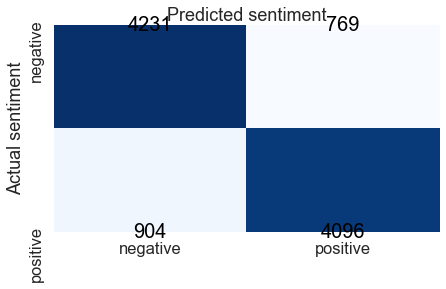

In [58]:
cnf_matrix_nb1 = confusion_matrix(y_test_nb1, y_pred_nb1)

class_names = ["negative", "positive"]
fig,ax = plt.subplots()

sns.heatmap(pd.DataFrame(cnf_matrix_nb1), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 20, "color":'black'})
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');

#### With Tfidf

In [59]:
X_train_nb2 = train_data_tf.copy()
y_train_nb2 = train_labels_tf.copy()
X_test_nb2 = test_data_tf.copy()
y_test_nb2 = test_labels_tf.copy()

In [60]:
alpha_scores=[]

for a in alpha_range:
    clf = MultinomialNB(alpha=a)
    scores = cross_val_score(clf, X_train_nb2, y_train_nb2, cv=5, scoring='accuracy')
    alpha_scores.append(scores.mean())
    print(a,scores.mean())

1 0.8799999999999999
6 0.8597333333333333
11 0.8482666666666667
16 0.8392
21 0.8326
26 0.8270666666666667
31 0.8228
36 0.8193333333333334
41 0.8164666666666667
46 0.8147333333333334


In [61]:
MSE = [1 - x for x in alpha_scores]

optimal_alpha_bnb = alpha_range[MSE.index(min(MSE))]

print(optimal_alpha_bnb)

1


In [62]:
nb_tlf = MultinomialNB(alpha=1)
nb_tlf.fit(X_train_nb2, y_train_nb2)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [63]:
pred_tlf = nb_tlf.predict(X_test_nb2)

In [64]:
#model accuracy
print("Accuracy:",metrics.accuracy_score(y_test_nb2, pred_tlf))

Accuracy: 0.8844


In [65]:
print(classification_report(y_test_nb2, pred_tlf))

              precision    recall  f1-score   support

          -1       0.87      0.90      0.89      5000
           1       0.90      0.86      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



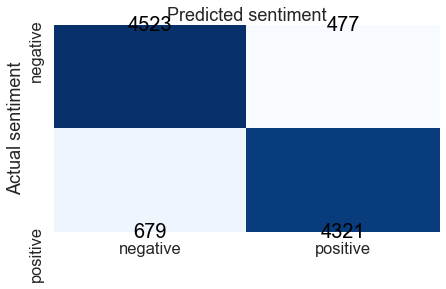

In [66]:
cnf_matrix_nb2 = confusion_matrix(y_test_nb2, pred_tlf)

class_names = ["negative", "positive"]
fig,ax = plt.subplots()

sns.heatmap(pd.DataFrame(cnf_matrix_nb2), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 20, "color":'black'})
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');

## 4. Conclusions

As shown above, the classes are equal - there are approximately the same number of positive and negative reviews. Therefore, accuracy score is a valid metric to evaluate the performance of the models. 

The Naive Bayes algorithm, trained with the data vectorised using the TfidfVectorizer, performed the best, achieving an accuracy of 0.8844, which means that it correctly classified the sentiment of 88% of the test reviews.